Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 140 rows, 130 columns and 520 nonzeros
Model fingerprint: 0x51a47084
Variable types: 30 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 20 rows and 11 columns
Presolve time: 0.01s
Presolved: 120 rows, 119 columns, 516 nonzeros
Variable types: 29 continuous, 90 integer (90 binary)

Root relaxation: objective 2.290525e+02, 33 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  229.05254    0   11          -  2

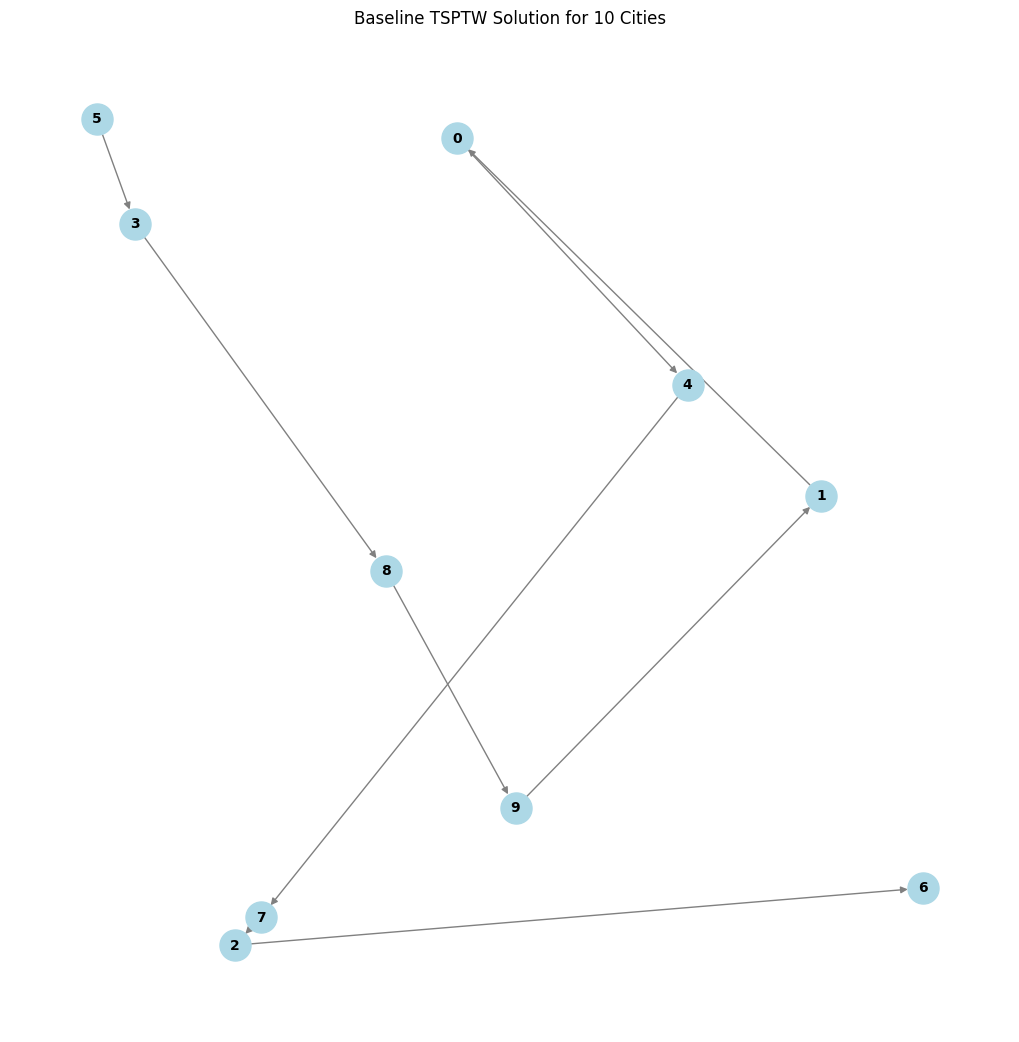

In [2]:
from gurobipy import Model, GRB, quicksum
from data_generation import generate_data
from visualizations import plot_tour_graph
import numpy as np

def solve_tsptw(num_cities, seed=42):
    coords, time_windows, travel_time = generate_data(num_cities, seed)
    model = Model()

    # Decision variables
    x = model.addVars(num_cities, num_cities, vtype=GRB.BINARY, name="x")
    z = model.addVars(num_cities, vtype=GRB.CONTINUOUS, name="z")
    w = model.addVars(num_cities, vtype=GRB.CONTINUOUS, name="w")
    h = model.addVars(num_cities, vtype=GRB.CONTINUOUS, name="h")

    # Objective function
    model.setObjective(
        quicksum(travel_time[i, j] * x[i, j] for i in range(num_cities) for j in range(num_cities))
        + quicksum(w[i] + h[i] for i in range(num_cities)),
        GRB.MINIMIZE,
    )

    # Constraints
    for i in range(num_cities):
        model.addConstr(quicksum(x[i, j] for j in range(num_cities)) == 1, name=f"Outflow_{i}")
        model.addConstr(quicksum(x[j, i] for j in range(num_cities)) == 1, name=f"Inflow_{i}")
        model.addConstr(x[i, i] == 0, name=f"NoSelfLoop_{i}")
        model.addConstr(w[i] >= time_windows[i, 0] - z[i], name=f"WaitingTime_{i}")
        model.addConstr(h[i] >= z[i] - time_windows[i, 1], name=f"LatePenalty_{i}")

    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                model.addConstr(z[j] >= z[i] + travel_time[i, j] * x[i, j] - (1e6 * (1 - x[i, j])), name=f"Subtour_{i}_{j}")

    model.optimize()

    # Capture solve time
    solve_time = model.Runtime

    if model.status == GRB.INFEASIBLE:
        print("Model is infeasible. Attempting feasibility relaxation...")
        model.feasRelaxS(0, False, False, True)
        model.optimize()

    if model.status == GRB.OPTIMAL:
        route = np.zeros((num_cities, num_cities))
        for i in range(num_cities):
            for j in range(num_cities):
                if x[i, j].X > 0.5:
                    route[i, j] = 1
        print(f"Solve Time: {solve_time} seconds")
        print(f"Objective Value (Time Cost): {model.ObjVal}")
        return coords, route, model.ObjVal, solve_time
    else:
        return coords, None, None, None

# Example usage
coords, route, obj_val, solve_time = solve_tsptw(10)
if route is not None:
    plot_tour_graph(coords, route, title="Baseline TSPTW Solution for 10 Cities")
